## Loading detector systematics
An example to demonstrate how detector systematics are loaded into the RunHistGenerator.

From the PELEE directory, the detector systematics data is generated using the `make_detsys.py` script as follows: 
```
python make_detsys.py --run 1 --selection NPBDT --preselection NP --output-file sandbox/atrettin/detsys_run1_nue_npbdt.json --binning-def "reco_e, 10, 0.15, 1.55"
```

In [1]:
# %load_ext autoreload
# %autoreload 2

In [2]:
import sys
sys.path.append("../../")
import data_loading as dl

In [3]:
from microfit.histogram import Binning, Histogram, HistogramGenerator, RunHistGenerator

data_pot = 1.0e20
# The query strings for the selection are defined in the `selections.py` file.
selection = "NPBDT"
preselection = "NP"
# Binnings are defined by the variable to be binned, the number of bins, and the range, and the label.
binning_def = ("reco_e", 10, (0.15, 1.55), r"Reconstructed Energy [GeV]")
binning = Binning.from_config(*binning_def)
# The binning is a class with a defined repr:
binning

Binning(variable='reco_e', bin_edges=array([0.15, 0.29, 0.43, 0.57, 0.71, 0.85, 0.99, 1.13, 1.27, 1.41, 1.55]), label='Reconstructed Energy [GeV]', is_log=False, selection_query=None)

In [4]:
from microfit.run_plotter import RunHistPlotter

RUN = ["1"]
all_truth_filters = [
    "nue",
    "drt",
    # remove the ones below to save some time
    # "nc_pi0",
    # "cc_pi0",
    # "cc_nopi",
    # "cc_cpi",
    # "nc_nopi",
    # "nc_cpi",
]
rundata, mc_weights, data_pot = dl.load_runs(
    RUN,
    data="bnb",
    truth_filtered_sets=all_truth_filters,
    loadpi0variables=True,
    loadshowervariables=True,
    loadrecoveryvars=True,
    loadsystematics=True,
    load_lee=False,
    enable_cache=True,
)

signal_generator = RunHistGenerator(
    rundata,
    binning,
    data_pot=data_pot,
    selection=selection,
    preselection=preselection,
    sideband_generator=None,
    uncertainty_defaults=None,
    detvar_data_path="detsys_run1_nue_npbdt.json",
)
plotter = RunHistPlotter(signal_generator, selection_title=None)
plotter.title = plotter.get_selection_title(selection=selection, preselection=preselection)

Text(0.5, 1.0, 'Detector Covariance, Run1, 1eNp Presel. and 1eNp BDT sel.')

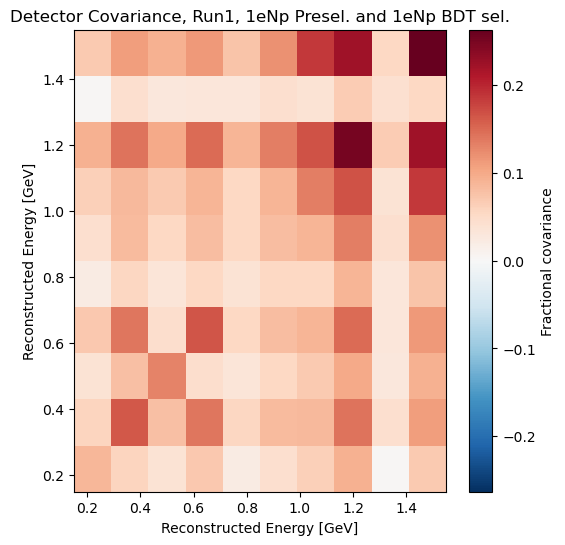

In [5]:
from matplotlib import pyplot as plt

tmp_histogram = signal_generator.get_mc_hist()
cov_mat_total= signal_generator.mc_hist_generator.calculate_detector_covariance()
tmp_histogram.covariance_matrix = cov_mat_total
fig, ax = plt.subplots(figsize=(6, 6))
tmp_histogram.draw_covariance_matrix(as_correlation=False, as_fractional=True, ax=ax)
ax.set_title(f"Detector Covariance, Run1, {plotter.title}")
# fig.savefig("detector_correlation_run1.pdf")

In [6]:
import logging

logging.basicConfig(level=logging.WARNING)

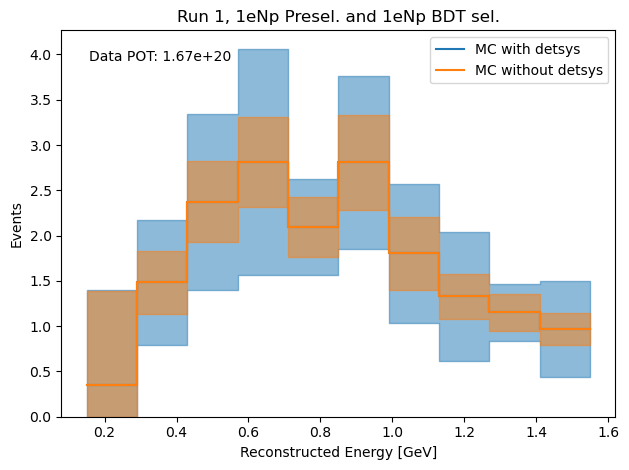

In [7]:
from matplotlib import pyplot as plt


hist_with_detsys = signal_generator.mc_hist_generator.generate(include_multisim_errors=True, add_precomputed_detsys=True)
hist_without_detsys = signal_generator.mc_hist_generator.generate(include_multisim_errors=True, add_precomputed_detsys=False)

fig, ax = plt.subplots()
hist_with_detsys.draw(ax=ax, label="MC with detsys")
hist_without_detsys.draw(ax=ax, label="MC without detsys")
ax.legend()
ax.set_xlabel(binning.label)
ax.set_ylim(bottom=0)  # set the minimum value of y axis to 0
ax.set_title("Run 1, "+ plotter.title)
pot_text = f"Data POT: {data_pot}"
plt.text(0.05, 0.95, pot_text, transform=ax.transAxes, ha='left', va='top')
fig.tight_layout()

<AxesSubplot:title={'center':'1eNp Presel. and 1eNp BDT sel.'}, xlabel='Reconstructed Energy [GeV]', ylabel='Events'>

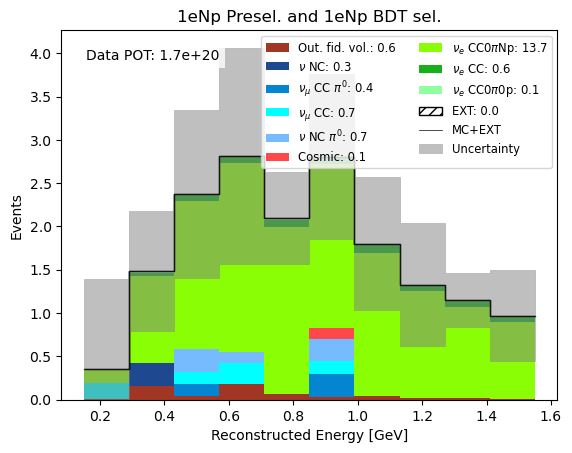

In [8]:
plotter.plot(add_ext_error_floor=False, category_column="category", include_multisim_errors=True, add_precomputed_detsys=True)

In [9]:
signal_generator2 = RunHistGenerator(
    rundata,
    binning,
    data_pot=data_pot,
    selection=selection,
    preselection=preselection,
    sideband_generator=None,
    uncertainty_defaults=None,
    detvar_data_path="detsys_run1_nue_npbdt.json",
)

Text(0.5, 1.0, 'Detector Covariance, Run1, 1eNp Presel. and 1eNp BDT sel.')

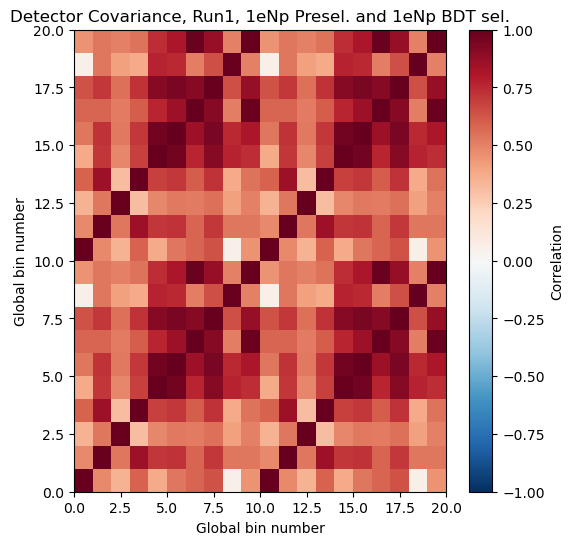

In [10]:
import numpy as np
from microfit.histogram import HistogramGenerator, Histogram, Binning, MultiChannelBinning, MultiChannelHistogram

hist_gen_1 = signal_generator.mc_hist_generator
hist_gen_2 = signal_generator2.mc_hist_generator

combined_covariance = HistogramGenerator.multiband_detector_covariance([hist_gen_1, hist_gen_2])

combined_binning = MultiChannelBinning([hist_gen_1.binning, hist_gen_2.binning])
hist_1 = hist_gen_1.generate()
hist_2 = hist_gen_2.generate()
concatenated_bin_counts = np.concatenate([hist_1.nominal_values, hist_2.nominal_values])
# plot covariance using a temporary histogram object as we did above
fig, ax = plt.subplots(figsize=(6, 6))
tmp_histogram = MultiChannelHistogram(combined_binning, concatenated_bin_counts, covariance_matrix=combined_covariance)
tmp_histogram.draw_covariance_matrix(as_correlation=True, as_fractional=False, ax=ax)
ax.set_title(f"Detector Covariance, Run1, {plotter.title}")
